<a href="https://colab.research.google.com/github/MamontLara/Italian_restaurant_sales/blob/main/Italian_restaurant_sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import calendar
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import bigquery
from google.oauth2 import service_account
import warnings


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Встановлюємо змінну середовища для аутентифікаці
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "drive/MyDrive/Dataset/my-educational-project-444514-40bb615d9aab.json"

In [4]:
# Налаштування клієнта BigQuery
client = bigquery.Client()

In [5]:
# Вимкнення повідомлень про попередження
warnings.filterwarnings("ignore")

In [6]:
# Функція для виконання SQL-запиту, перетворення результату в DataFrame та виведення
def execute_and_print_query(query: str) -> pd.DataFrame:
   query_job = client.query(query)
   df = query_job.to_dataframe()
   display(df)
   return df

In [7]:
# Перевіряємо підключення, знайомимося з даними.
query_1 = f"""
SELECT *
FROM `my-educational-project-444514.Restaurant_sales.Italian_sales`
LIMIT 5;
"""

df_1 = execute_and_print_query(query_1)

,Date,Time,Menu_Item,Category,Quantity,Price_per_item,Revenue,Payment_Method,Customer_Type
0,2024-12-04,06:45 AM,Gelato,Dessert,1,4.5,4.5,Mobile Payment,Dine-In
1,2024-01-08,06:51 PM,Gelato,Dessert,1,4.5,4.5,Credit Card,Dine-In
2,2024-07-08,10:40 AM,Gelato,Dessert,1,4.5,4.5,Mobile Payment,Dine-In
3,2024-10-30,02:39 PM,Gelato,Dessert,1,4.5,4.5,Mobile Payment,Dine-In
4,2024-10-05,06:19 PM,Gelato,Dessert,1,4.5,4.5,Cash,Dine-In


In [8]:
# Отримуємо назву колонок та їх тип
query_2 = f"""
SELECT
    column_name,
    data_type
FROM `my-educational-project-444514.Restaurant_sales.INFORMATION_SCHEMA.COLUMNS`
WHERE table_name = 'Italian_sales';
"""

df_2 = execute_and_print_query(query_2)

,column_name,data_type
0,Date,DATE
1,Time,STRING
2,Menu_Item,STRING
3,Category,STRING
4,Quantity,INT64
5,Price_per_item,FLOAT64
6,Revenue,FLOAT64
7,Payment_Method,STRING
8,Customer_Type,STRING


In [9]:
# Перевіряємо датасет на null.
query_3  = """
SELECT
    SUM(CASE WHEN Date IS NULL THEN 1 ELSE 0 END) AS null_in_Date,
    SUM(CASE WHEN Time IS NULL THEN 1 ELSE 0 END) AS null_in_Time,
    SUM(CASE WHEN Menu_Item IS NULL THEN 1 ELSE 0 END) AS null_in_Menu_Item,
    SUM(CASE WHEN Category IS NULL THEN 1 ELSE 0 END) AS null_in_Category,
    SUM(CASE WHEN Quantity IS NULL THEN 1 ELSE 0 END) AS null_in_Quantity,
    SUM(CASE WHEN Price_per_item IS NULL THEN 1 ELSE 0 END) AS null_in_Price_per_item,
    SUM(CASE WHEN Revenue IS NULL THEN 1 ELSE 0 END) AS null_in_Revenue,
    SUM(CASE WHEN Payment_Method IS NULL THEN 1 ELSE 0 END) AS null_in_Payment_Method,
    SUM(CASE WHEN Customer_Type IS NULL THEN 1 ELSE 0 END) AS null_in_Customer_Type
FROM `my-educational-project-444514.Restaurant_sales.Italian_sales`;
"""

df_null = execute_and_print_query(query_3)

,null_in_Date,null_in_Time,null_in_Menu_Item,null_in_Category,null_in_Quantity,null_in_Price_per_item,null_in_Revenue,null_in_Payment_Method,null_in_Customer_Type
0,0,0,0,0,0,0,0,0,0


Датасет не містить null значень.



In [10]:
# Перевіряємо датасет на дублікати.
query_4 = f"""
SELECT
    Date,
    Time,
    Menu_Item,
    Category,
    Quantity,
    Price_per_item,
    Revenue,
    Payment_Method,
    Customer_Type,
    COUNT(*) AS Duplicate_Count
FROM `my-educational-project-444514.Restaurant_sales.Italian_sales`
GROUP BY
    Date,
    Time,
    Menu_Item,
    Category,
    Quantity,
    Price_per_item,
    Revenue,
    Payment_Method,
    Customer_Type
HAVING COUNT(*) > 1
ORDER BY Duplicate_Count DESC;
"""

df_4 = execute_and_print_query(query_4)

,Date,Time,Menu_Item,Category,Quantity,Price_per_item,Revenue,Payment_Method,Customer_Type,Duplicate_Count


Датасет не містить дублікатів.

In [11]:
# Перевіряємо числові колонки на від'ємні значення.
query_5 = f"""
SELECT *
FROM `my-educational-project-444514.Restaurant_sales.Italian_sales`
WHERE Quantity < 0 OR Price_per_item < 0 OR Revenue < 0;
"""

df_5 = execute_and_print_query(query_5)

,Date,Time,Menu_Item,Category,Quantity,Price_per_item,Revenue,Payment_Method,Customer_Type


Числові колонки датасету не містять від'ємних значень.

In [12]:
# Перевіряємо чи у датасет увійшли дані лише за 2024 рік.
query_6 = f"""
SELECT *
FROM `my-educational-project-444514.Restaurant_sales.Italian_sales`
WHERE EXTRACT(YEAR FROM Date) != 2024
"""

df_6 = execute_and_print_query(query_6)

,Date,Time,Menu_Item,Category,Quantity,Price_per_item,Revenue,Payment_Method,Customer_Type


Датасет містить дані лише за 2024 рік.

In [13]:
# Перевіряємо датасет на наявність сторонніх значень
query_7 = f"""
SELECT
    'Category' AS Column_Name,
    Category AS Unique_Value
FROM `my-educational-project-444514.Restaurant_sales.Italian_sales`
GROUP BY Category
UNION ALL
SELECT
    'Menu_Item' AS Column_Name,
    Menu_Item AS Unique_Value
FROM `my-educational-project-444514.Restaurant_sales.Italian_sales`
GROUP BY Menu_Item
UNION ALL
SELECT
    'Payment_Method' AS Column_Name,
    Payment_Method AS Unique_Value
FROM `my-educational-project-444514.Restaurant_sales.Italian_sales`
GROUP BY Payment_Method
UNION ALL
SELECT
    'Customer_Type' AS Column_Name,
    Customer_Type AS Unique_Value
FROM `my-educational-project-444514.Restaurant_sales.Italian_sales`
GROUP BY Customer_Type;
"""

df_7 = execute_and_print_query(query_7)

,Column_Name,Unique_Value
0,Customer_Type,Dine-In
1,Customer_Type,Delivery
2,Customer_Type,Takeaway
3,Category,Dessert
4,Category,Appetizer
5,Category,Main Course
6,Payment_Method,Mobile Payment
7,Payment_Method,Credit Card
8,Payment_Method,Cash
9,Menu_Item,Gelato


Дані перевірені на наявність неочікуваних або сторонніх значень, і всі значення відповідають очікуванням відповідно до бізнес-логіки.

In [14]:
# Перевіряємо основні характеристики числових колонок
query_8 = f"""
SELECT
  MIN(Quantity) AS Min_Quantity,
  MAX(Quantity) AS Max_Quantity,
  AVG(Quantity) AS Avg_Quantity,
  MIN(Price_per_item) AS Min_Price,
  MAX(Price_per_item) AS Max_Price,
  AVG(Price_per_item) AS Avg_Price,
  MIN(Revenue) AS Min_Revenue,
  MAX(Revenue) AS Max_Revenue,
  AVG(Revenue) AS Avg_Revenue
FROM `my-educational-project-444514.Restaurant_sales.Italian_sales`
"""

df_8 = execute_and_print_query(query_8)

,Min_Quantity,Max_Quantity,Avg_Quantity,Min_Price,Max_Price,Avg_Price,Min_Revenue,Max_Revenue,Avg_Revenue
0,1,5,2.978,4.5,13.0,8.32485,4.5,65.0,24.77305


Основні характеристики числових колонок у таблиці Italian_sales:

Кількість (Quantity):
Мінімальне значення: 1, що означає, що кожна транзакція включає щонайменше один товар.
Максимальне значення: 5, що вказує на те, що деякі замовлення складаються з кількох одиниць одного товару.
Середнє значення: 2.978.

Ціна за одиницю (Price_per_item):
Мінімальне значення: 4.5, що, ймовірно, є ціною найдешевшого товару.
Максимальне значення: 13.0, що відповідає найдорожчому товару в меню.
Середнє значення: 8.32485, що показує, що середня ціна товару перебуває в середньому діапазоні.

Доходи (Revenue):
Мінімальне значення: 4.5, що може бути пов’язане з продажем одного найдешевшого товару.
Максимальне значення: 65.0, що свідчить про наявність замовлень із високою вартістю.
Середнє значення: 24.77305.
Отже, дані свідчать про те, що більшість замовлень включають кілька одиниць товарів середньої вартості.

In [15]:
# Підрахуємо загальний дохід за 2024 рік.
query_9 = f"""
SELECT SUM(Revenue) AS Total_Revenue
FROM `my-educational-project-444514.Restaurant_sales.Italian_sales`
"""

df_9 = execute_and_print_query(query_9)

,Total_Revenue
0,247730.5


Отже, дохід за 2024 рік склав 247730.5$.

# 1. Розподіл доходу за категоріями меню.
(Яка категорія меню приносить найбільший дохід?)

,Category,Category_Revenue
0,Main Course,139581.5
1,Appetizer,57608.0
2,Dessert,50541.0


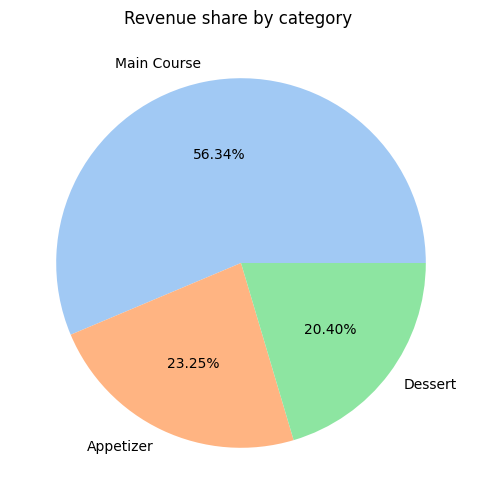

In [16]:
# Підраховуємо дохід, що отримуємо з кожної категорії.
query_10 = f"""
SELECT
    Category,
    SUM(Revenue) AS Category_Revenue
FROM `my-educational-project-444514.Restaurant_sales.Italian_sales`
GROUP BY Category
ORDER BY Category_Revenue DESC;
"""

df_10 = execute_and_print_query(query_10)

plt.figure(figsize=(10, 6))
plt.pie(df_10['Category_Revenue'], labels=df_10['Category'], autopct='%1.2f%%', colors=sns.color_palette('pastel'))
plt.title('Revenue share by category ')
plt.show()

Дані показують, що найбільший дохід отримується з Основного меню - 56,34% (	Main Course - 139581,5), далі йдуть Закуски - 23.25% (Appetizer	- 57608.0), а найменший дохід отримано з Десертів - 20.40% (Dessert -	50541.0).

# 2. Розподіл доходу на рівні окремих страв у розрізі категорій.
(Які страви приносять найбльший/найменший дохід?)

,Category,Menu_Item,Item_Revenue
0,Main Course,Fettuccine Alfredo,40157.0
1,Main Course,Spaghetti Carbonara,35796.0
2,Main Course,Lasagna,34488.5
3,Main Course,Margherita Pizza,29140.0
4,Appetizer,Caprese Salad,22568.0
5,Appetizer,Minestrone Soup,20930.0
6,Dessert,Tiramisu,20462.0
7,Dessert,Panna Cotta,16588.0
8,Appetizer,Bruschetta,14110.0
9,Dessert,Gelato,13491.0


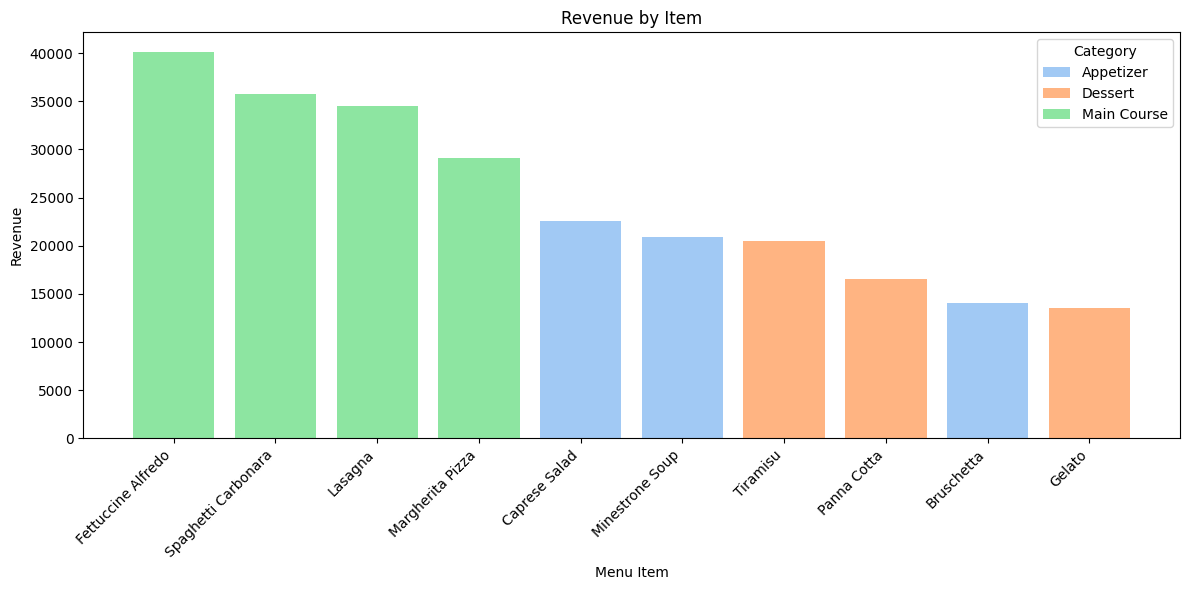

In [17]:
# Підраховуємо дохід, який  приносить кожна страва.
query_11 = f"""
SELECT
    Category,
    Menu_Item,
    SUM(Revenue) AS Item_Revenue
FROM `my-educational-project-444514.Restaurant_sales.Italian_sales`
GROUP BY Category, Menu_Item
ORDER BY Item_Revenue DESC;
"""

df_11 = execute_and_print_query(query_11)

# Закріпимо кольори, щоб на графіках мати однакові кольори категорій.
categories = sorted(df_11['Category'].unique())
palette = sns.color_palette("pastel", len(categories))
category_colors = {category: palette[i] for i, category in enumerate(categories)}
bar_colors = df_11['Category'].map(category_colors)

plt.figure(figsize=(12, 6))
plt.bar(df_11['Menu_Item'], df_11['Item_Revenue'], color=bar_colors)
plt.title('Revenue by Item')
plt.xlabel('Menu Item')
plt.ylabel('Revenue')
plt.xticks(rotation=45, ha='right')

for category, color in category_colors.items():
    plt.bar(0, 0, color=color, label=category)
plt.legend(title="Category", loc="upper right", fontsize=10)

plt.tight_layout()
plt.show()

У категорії Основні страви найбільший дохід приносить Феттучіне Альфредо - 40157.0, далі йдуть Спагеті Карбонара та Лазанья. У категорії Закуски лідирує Салат "Капрезе" - 22568.0. Серед десертів найбільший дохід має Тірамісу - 20462.0, а найменший Джелато - 13491.0. Загалом, позиції Основні страви приносять більший дохід порівняно з Закусками та Десертами.


# 3. Динаміка доходу за категоріями страв протягом року для виявлення сезонності для категорій меню.
(Чи залежить дохід від сезону?)

In [18]:
# Розраховуємо помісячний дохід різних категорій страв.
query_12 = f"""
SELECT
    EXTRACT(MONTH FROM Date) AS Month,
    Category, SUM(Revenue) AS Monthly_Revenue
FROM `my-educational-project-444514.Restaurant_sales.Italian_sales`
GROUP BY Month, Category
ORDER BY Month, Monthly_Revenue DESC;
"""

df_12 = execute_and_print_query(query_12)

,Month,Category,Monthly_Revenue
0,1,Main Course,11428.0
1,1,Dessert,4570.5
2,1,Appetizer,3873.0
3,2,Main Course,10864.5
4,2,Appetizer,4680.0
5,2,Dessert,3568.5
6,3,Main Course,11958.0
7,3,Appetizer,5081.0
8,3,Dessert,4178.5
9,4,Main Course,11153.5


In [19]:
# Функція для перетворення чисел у текстові назви місяців для зручності перегляду.
def get_month_labels():
    return ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
            'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

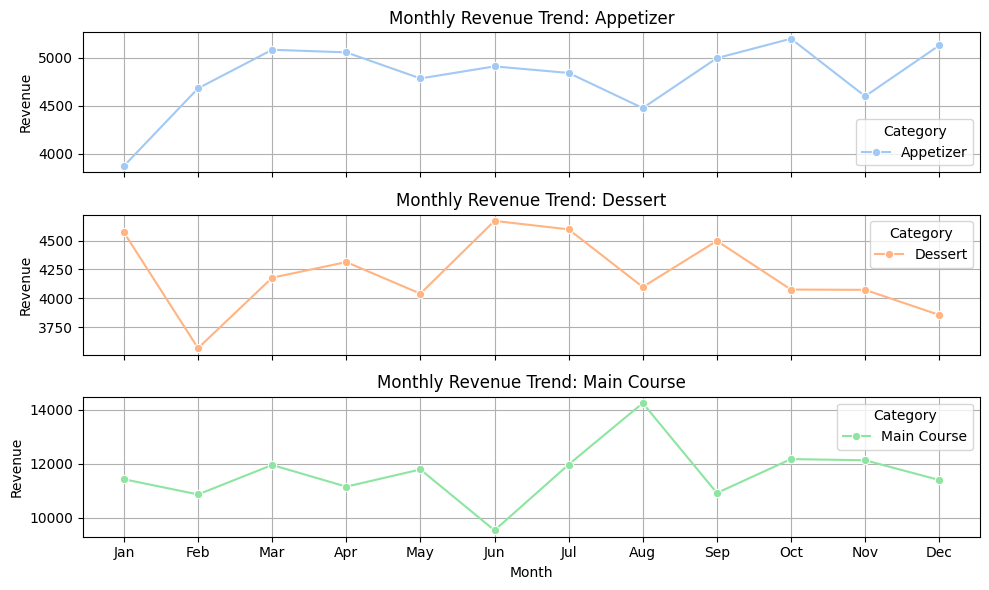

In [20]:
# Динаміка доходу по різних категоріях протягом року.
fig, axes = plt.subplots(3, 1, figsize=(10, 6), sharex=True)

for i, category in enumerate(categories):
    category_data = df_12[df_12['Category'] == category]
    sns.lineplot(ax=axes[i], data=category_data, x='Month', y='Monthly_Revenue', marker='o', color=palette[i], label=category)
    # Налаштовуємо кожен підграфік.
    axes[i].set_title(f'Monthly Revenue Trend: {category}')
    axes[i].set_xlabel('Month')
    axes[i].set_ylabel('Revenue')
    axes[i].set_xticks(range(1, 13))
    axes[i].set_xticklabels(get_month_labels())
    axes[i].legend(title="Category")
    axes[i].grid(True)

plt.tight_layout()
plt.show()

Кожна з категорій меню має свою сезонність продажів.

**Закуски:**
Продажі закусок мають мінімум у січні, тоді як протягом решти року доходи залишаються стабільними з максимумом у жовтні. Для підвищення продажів у січні можна розглянути такі стратегії: комбіновані пропозиції - поєднання закусок із категорією, що добре продається цього місяця, наприклад, з Десертами. Наприклад, запропонувати акцію: "Купуйте закуску та отримуйте знижку на десерт".
Спеціальні акції: створення обмежених пропозицій, наприклад, "Зимовий сет закусок" або знижки на популярні закуски.
Маркетингова кампанія: акцент на сезонних зимових закусках через соціальні мережі або розсилки, щоб залучити більше клієнтів.

**Десерти:**
Динаміка продажів десертів менш стабільна, з піком у червні та мінімумом у лютому. Наприкінці року також спостерігається спад.
Сезонні десерти: додати новий десерт, який підходить для святкової новорічної пори, наприклад, різдвяні пряники, шоколадні трюфелі чи десерти зі смаком спецій (кориця, імбир).
Замінити слабкі позиції: переглянути асортимент і виключити десерти, що мають найнижчі продажі, замінивши їх на нові, які відповідають запитам клієнтів.
Пропозиції для лютого: враховуючи, що лютий — це місяць Дня Святого Валентина, варто створити романтичні десерти для пар або акції "2 за ціною 1".

**Основні страви:**
Продажі основних страв доволі стабільні протягом року, з певним мінімумом у червні та максимумом у серпні.
Адаптація меню влітку: у червні, коли продажі основних страв знижуються, варто розглянути пропозиції легких літніх варіантів (н-д, страви на грилі).
Акцент на сезонність у серпні: під час піку продажів у серпні можна посилити маркетингові кампанії, що підкреслюють популярність літніх основних страв, щоб максимізувати дохід.

*Комбо-меню*: створити комплекти, які включають основну страву, закуску або десерт, щоб залучити більше клієнтів.

# 4. Динаміка доходу за типами страв протягом року.
(Який максимальний/мінімальний дохід мають страви протягом року?)

In [21]:
# Місячний дохід кожної страви.
query_13 = f"""
SELECT
    EXTRACT(MONTH FROM Date) AS Month,
    Menu_Item,
    SUM(Revenue) AS Monthly_Revenue
FROM `my-educational-project-444514.Restaurant_sales.Italian_sales`
GROUP BY Month, Menu_Item
ORDER BY Monthly_Revenue DESC;
"""

df_13 = execute_and_print_query(query_13)

,Month,Menu_Item,Monthly_Revenue
0,8,Spaghetti Carbonara,4164.0
1,8,Fettuccine Alfredo,3822.0
2,5,Fettuccine Alfredo,3757.0
3,7,Fettuccine Alfredo,3744.0
4,3,Fettuccine Alfredo,3705.0
...,...,...,...
115,5,Bruschetta,1055.0
116,2,Bruschetta,1015.0
117,12,Panna Cotta,1006.5
118,2,Gelato,994.5


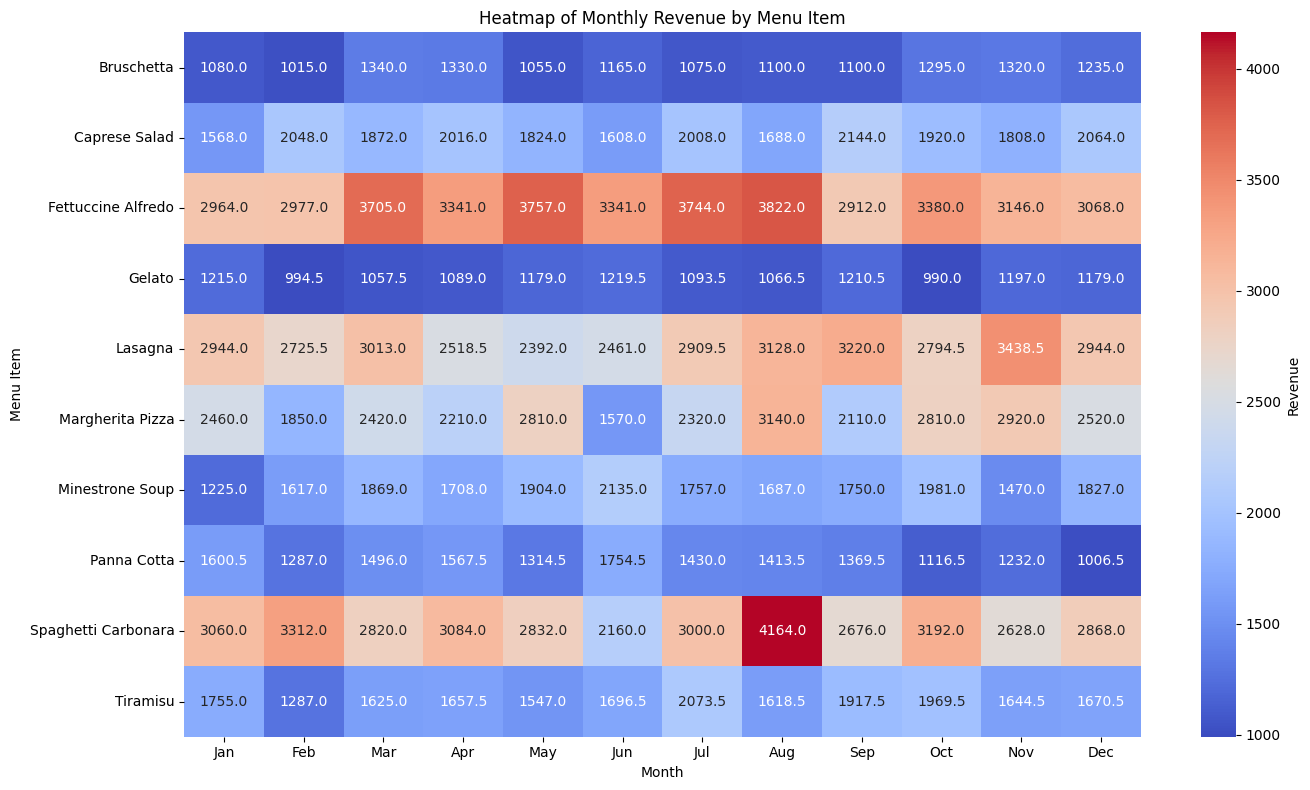

In [22]:
# Зведена таблиця доходів по кожному пункту меню протягом року.
menu_table = df_13.pivot(index='Menu_Item', columns='Month', values='Monthly_Revenue')
menu_table.columns = get_month_labels()

plt.figure(figsize=(14, 8))
sns.heatmap(menu_table, annot=True, fmt=".1f", cmap='coolwarm', cbar_kws={'label': 'Revenue'})
plt.title("Heatmap of Monthly Revenue by Menu Item")
plt.xlabel("Month")
plt.ylabel("Menu Item")
plt.tight_layout()
plt.show()

Сезонність доходів по стравах меню:

Паста Карбонара показує найбільший пік доходу в липні (4164.0), що свідчить про популярність цієї страви в літні місяці.
Феттучіне Альфредо та Лазанья мають стабільний дохід протягом року, але з невеликими піками в березні та серпні.
Десерти (Тірамісу, Панна Котта, Джелато) мають менший дохід порівняно з основними стравами, але стабільність у них вища, без різких перепадів.
Джелато (морозиво) має досить рівний дохід, але має загалом низький дохід протягом року.

Джелато та Брускети мають найнижчі доходи порівняно з іншими стравами. Можливо, варто розглянути їхню популярність і актуальність у меню.

# 5. Розподіл доходу для кожного типу клієнта: Dine-In, Delivery, Takeaway.
(Який тип клієнта приносить найбільший дохід?)

In [23]:
# Загальний дохід за типом клієнта.
query_14 = f"""
SELECT Customer_Type, SUM(Revenue) AS Total_Revenue
FROM `my-educational-project-444514.Restaurant_sales.Italian_sales`
GROUP BY Customer_Type
ORDER BY Total_Revenue DESC;
"""
df_14 = execute_and_print_query(query_14)

,Customer_Type,Total_Revenue
0,Dine-In,83433.5
1,Takeaway,82761.0
2,Delivery,81536.0


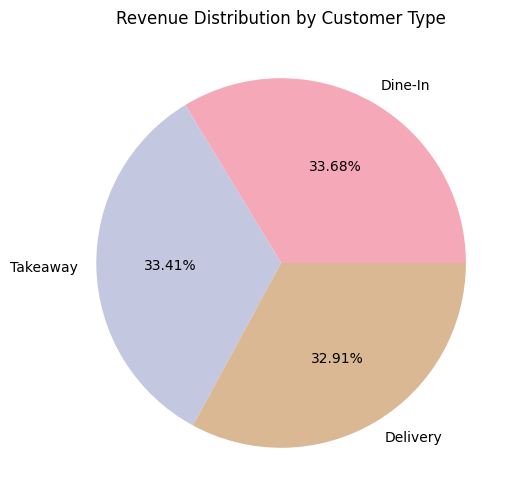

In [24]:
# Встановлюємо кольори, відмінні від кольорів категорій меню.
customer_types = sorted(df_14['Customer_Type'].unique())
customer_palette = sns.color_palette(["#DAB894", "#F5A9B8", "#C3C8E0"])
customer_colors = {customer: customer_palette[i % len(customer_palette)] for i, customer in enumerate(customer_types)}
pie_colors = [customer_colors[customer] for customer in df_14['Customer_Type']]

plt.figure(figsize=(6, 6))
plt.pie(df_14['Total_Revenue'], labels=df_14['Customer_Type'], autopct='%1.2f%%', colors=pie_colors)
plt.title("Revenue Distribution by Customer Type")
plt.show()

Дані свідчать, що доходи розподілені приблизно рівномірно між усіма типами клієнтів (Delivery, Dine-In, Takeaway), де кожен тип клієнта забезпечує близько 33% від загального доходу. Це свідчить про те, що жоден тип клієнта не домінує, і доходи між ними рівномірно розподіляються.

# 6. Дохід за типами клієнтів у розрізі категорій меню.
(Дослідження впливу клієнтського сегменту на популярність категорій)

In [25]:
# Аналіз популярності страв за типом клієнта
query_15 = f"""
SELECT Customer_Type, Category, SUM(Revenue) AS Total_Revenue
FROM `my-educational-project-444514.Restaurant_sales.Italian_sales`
GROUP BY Customer_Type, Category
ORDER BY Customer_Type, Total_Revenue DESC;
"""

df_15 = execute_and_print_query(query_15)

,Customer_Type,Category,Total_Revenue
0,Delivery,Main Course,45436.5
1,Delivery,Appetizer,19033.0
2,Delivery,Dessert,17066.5
3,Dine-In,Main Course,47219.5
4,Dine-In,Appetizer,19870.0
5,Dine-In,Dessert,16344.0
6,Takeaway,Main Course,46925.5
7,Takeaway,Appetizer,18705.0
8,Takeaway,Dessert,17130.5


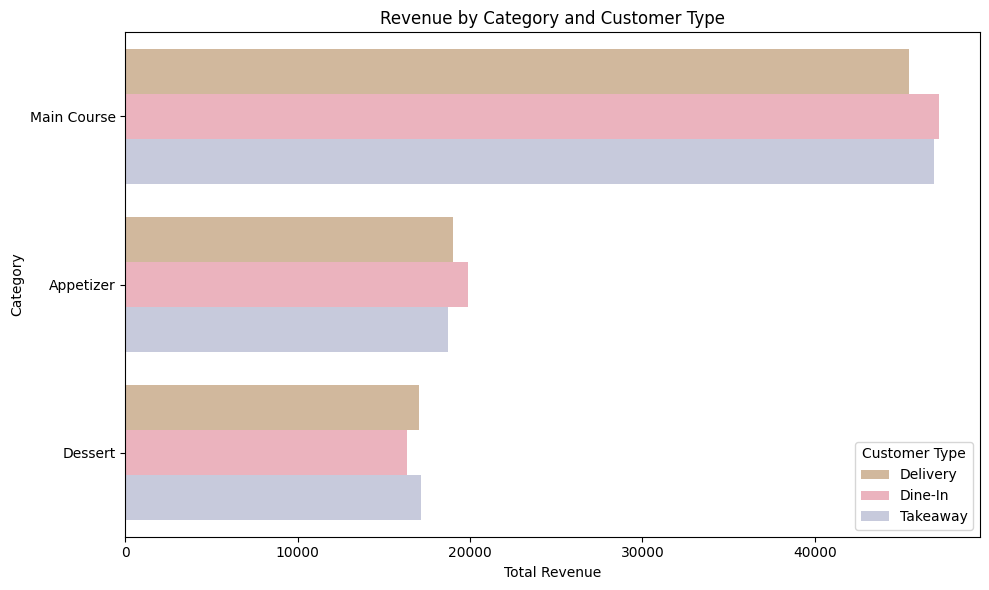

In [26]:
plt.figure(figsize=(10, 6))

sns.barplot(data=df_15, y='Category', x='Total_Revenue', hue='Customer_Type', palette=customer_colors)

plt.title('Revenue by Category and Customer Type')
plt.xlabel('Total Revenue')
plt.ylabel('Category')
plt.legend(title='Customer Type')
plt.tight_layout()
plt.show()

Обслуговування клієнтів у закладі ("Dine-In") приносить найбільший дохід, особливо в Основних стравах, що підкреслює важливість покращення атмосфери та якості обслуговування в ресторані. Замовлення на виніс ("Takeaway") має дещо менший дохід, але може стати точкою росту, якщо впровадити програми лояльності чи інші стимули. Доставка ("Delivery") демонструє менший попит, займаючи третє місце за доходом, особливо в категорії основних страв, що свідчить про її потенціал для подальшого розвитку, наприклад, через спеціальні пропозиції чи швидкість доставки, що дуже важливо для категорії Основних страв.

In [27]:
# Відсотковий розподіл доходу в категорії за типом клієнта.
df_15['Percentage_Revenue'] = df_15.groupby('Category')['Total_Revenue'].transform(lambda x: (x / x.sum()) * 100)
print(df_15)


  Customer_Type     Category  Total_Revenue  Percentage_Revenue
0      Delivery  Main Course        45436.5           32.551950
1      Delivery    Appetizer        19033.0           33.038814
2      Delivery      Dessert        17066.5           33.767634
3       Dine-In  Main Course        47219.5           33.829340
4       Dine-In    Appetizer        19870.0           34.491737
5       Dine-In      Dessert        16344.0           32.338102
6      Takeaway  Main Course        46925.5           33.618710
7      Takeaway    Appetizer        18705.0           32.469449
8      Takeaway      Dessert        17130.5           33.894264


In [28]:
query_16 = """
SELECT
    Customer_Type,
    AVG(Revenue) AS Average_Revenue_Per_Customer
FROM `my-educational-project-444514.Restaurant_sales.Italian_sales`
GROUP BY Customer_Type
ORDER BY Average_Revenue_Per_Customer DESC;
"""

df_16 = execute_and_print_query(query_16)

,Customer_Type,Average_Revenue_Per_Customer
0,Dine-In,24.883239
1,Delivery,24.873703
2,Takeaway,24.565450


Можна зробити висновок, що доходи залежні від типу страви, а не від типу клієнта. Порівнюючи дані, ми бачимо, що тип страви має значний вплив на дохід. Наприклад, головні страви мають найвищий дохід серед усіх категорій у кожній групі типів клієнтів (Delivery, Dine-In, Takeaway). Порівнявши доходи різних типів клієнтів, можна зробити висновок, що тип клієнта (Delivery, Dine-In, Takeaway) не має значного впливу на загальний дохід, оскільки всі три категорії приблизно рівні за дохідністю. Як видно з другого набору результатів, доходи розподілені приблизно рівномірно між усіма типами клієнтів (Delivery, Dine-In, Takeaway), де кожен тип клієнта забезпечує близько 33% від загального доходу. Це свідчить про те, що жоден тип клієнта не домінує, і доходи між ними рівномірно розподіляються.

# 7. Річна динаміка доходів різних типів клієнтів.
(Яка динаміка є серед замовлень різними типами клієнтів протягом року?)

In [29]:
query_17 = """
SELECT
    EXTRACT(MONTH FROM Date) AS Month,
    Customer_Type,
    SUM(Revenue) AS Monthly_Revenue_By_Type
FROM `my-educational-project-444514.Restaurant_sales.Italian_sales`
GROUP BY Month, Customer_Type
ORDER BY Month, Monthly_Revenue_By_Type DESC;
"""

df_17 = execute_and_print_query(query_17)

,Month,Customer_Type,Monthly_Revenue_By_Type
0,1,Takeaway,6969.5
1,1,Delivery,6638.5
2,1,Dine-In,6263.5
3,2,Dine-In,7165.5
4,2,Delivery,6258.5
5,2,Takeaway,5689.0
6,3,Takeaway,7292.0
7,3,Dine-In,7148.0
8,3,Delivery,6777.5
9,4,Dine-In,7215.0


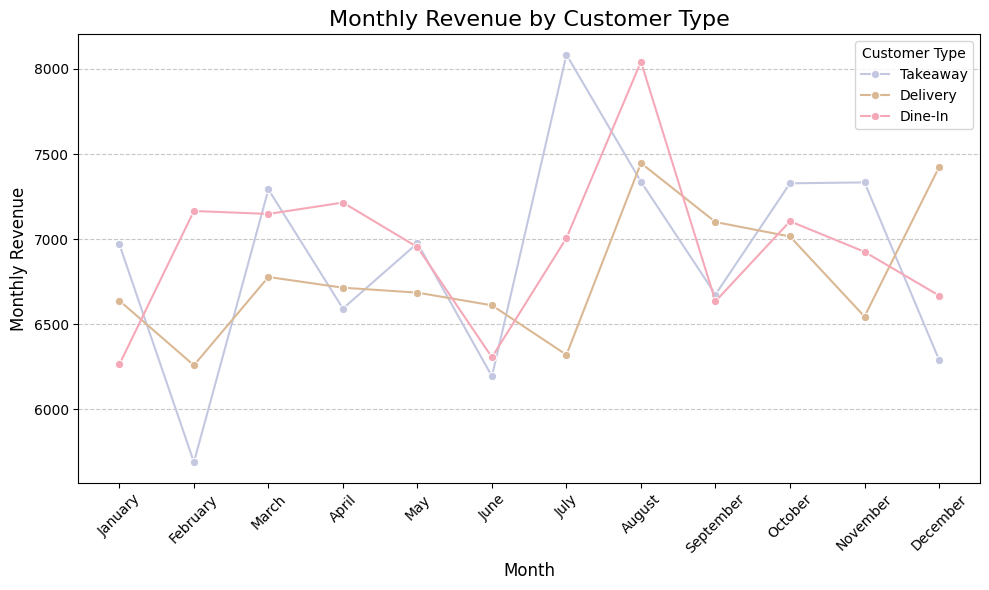

In [30]:
df_17['Month'] = df_17['Month'].apply(lambda x: calendar.month_name[x] if isinstance(x, int) else x)
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_17, x='Month', y='Monthly_Revenue_By_Type', hue='Customer_Type', marker='o', palette=customer_colors)
plt.title('Monthly Revenue by Customer Type', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Monthly Revenue', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Customer Type', loc='upper right')
plt.tight_layout()
plt.show()

Зміни в доходах протягом року:

Доходи різних типів клієнтів змінюються від місяця до місяця.
Найвищі доходи отримуються в літні місяці (липень і серпень), особливо від клієнтів "Takeaway" та "Dine-In". Найменші доходи спостерігаються в зимові місяці (січень і лютий), особливо, для страв на виніс, то необхідно продумати  спеціальні акції чи акусесуари, які б підвищили дохід у лютому.


# 8. Розподіл доходу за методами оплати.
(Який спосіб оплати найпопулярніший?)

In [31]:
query_18 = """
SELECT
    Payment_Method,
    SUM(Revenue) AS Total_Revenue
FROM `my-educational-project-444514.Restaurant_sales.Italian_sales`
GROUP BY Payment_Method
ORDER BY Total_Revenue DESC;
"""

df_18 = execute_and_print_query(query_18)

,Payment_Method,Total_Revenue
0,Cash,84541.5
1,Mobile Payment,82480.5
2,Credit Card,80708.5


Готівкою (Cash) клієнти розраховуються найчастіше (84,541.5). Мобільні платежі (Mobile Payment) знаходяться на другому місці способои розрахунку (82,480.5). Кредитні картки (Credit Card) займають третє місце (80,708.5). Отже, мобільні платежі і кредитні картки менш популярні методи оплати, але різниця між усіма трьома способами не значна.

# 9. Розподіл доходів у розрізі типу клієнта та методу оплати.
(Який тип оплати обирають різні типи клієнтів?)

In [32]:
query_19 = """
SELECT
    Customer_Type,
    Payment_Method,
    SUM(Revenue) AS Total_Revenue
FROM `my-educational-project-444514.Restaurant_sales.Italian_sales`
GROUP BY Customer_Type, Payment_Method
ORDER BY Total_Revenue DESC;
"""

df_19 = execute_and_print_query(query_19)

,Customer_Type,Payment_Method,Total_Revenue
0,Dine-In,Cash,28867.5
1,Takeaway,Credit Card,28309.0
2,Delivery,Mobile Payment,28251.0
3,Delivery,Cash,27901.5
4,Takeaway,Cash,27772.5
5,Dine-In,Mobile Payment,27550.0
6,Dine-In,Credit Card,27016.0
7,Takeaway,Mobile Payment,26679.5
8,Delivery,Credit Card,25383.5


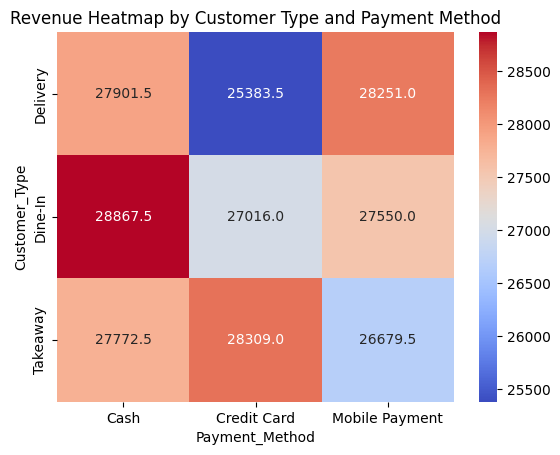

In [33]:
# Зведена таблиця різних типів оплати за типом клієнта.
pivot_data = df_19.pivot_table(values='Total_Revenue', index='Customer_Type', columns='Payment_Method', aggfunc='sum')
sns.heatmap(pivot_data, annot=True, cmap="coolwarm", fmt='.1f')
plt.title("Revenue Heatmap by Customer Type and Payment Method")
plt.show()

Типи клієнтів та методи оплати:

Dine-In найбільше використовує готівку (Cash), хоча також використовуються мобільні платежі та кредитні картки.
Takeaway найбільше використовує кредитні картки (Credit Card), що вказує на високу зручність цього методу для страв на виніс.
Delivery переважно використовує мобільні платежі (Mobile Payment), що може бути зручним для онлайн-замовлень. Найбільший дохід серед методів оплати приносять
Dine-In з готівкою. Також цікавим є низьке використання мобільної оплати для страв на виніс та кредитної картки для Доставки, хоча різниця у платежах досить невелика.

# 10. Динаміка доходу протягом року.
(Який місяць є найприбутковішим?).

In [34]:
query_20= """
SELECT
    EXTRACT(MONTH FROM Date) AS Month,
        SUM(Revenue) AS Monthly_Revenue
FROM `my-educational-project-444514.Restaurant_sales.Italian_sales`
GROUP BY Month
ORDER BY Month;
"""

df_20 = execute_and_print_query(query_20)

,Month,Monthly_Revenue
0,1,19871.5
1,2,19113.0
2,3,21217.5
3,4,20521.5
4,5,20614.5
5,6,19110.5
6,7,21410.5
7,8,22827.5
8,9,20409.5
9,10,21448.5


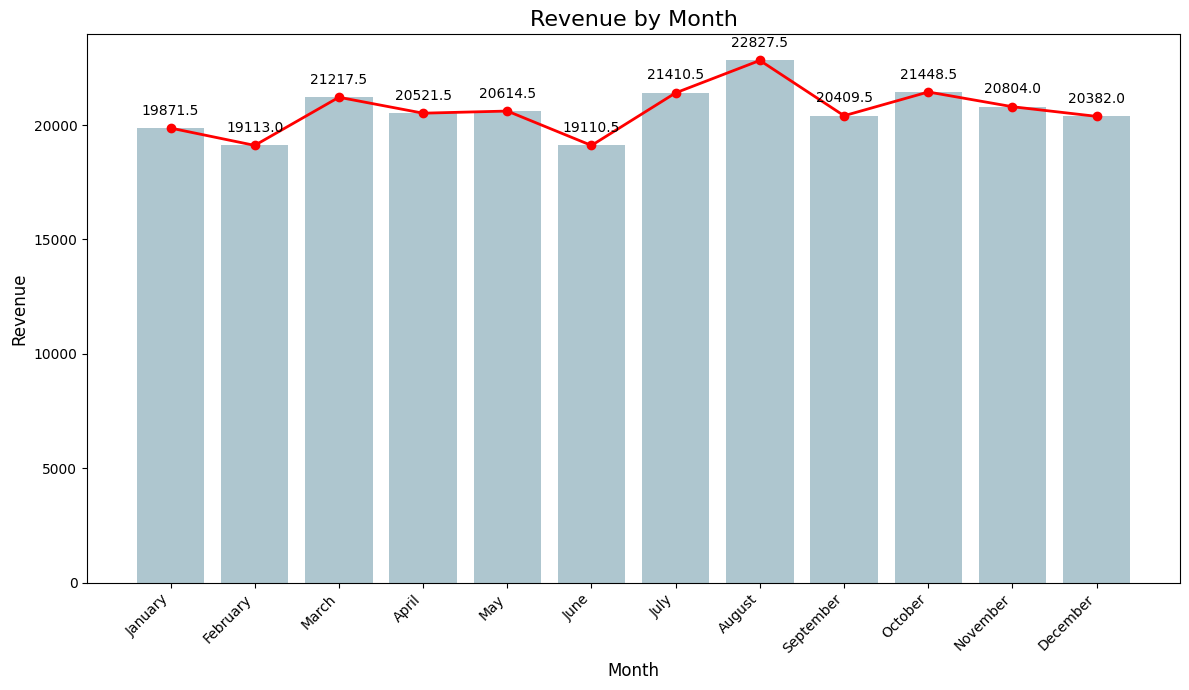

In [35]:
# Динаміка доходу по місяцях протягом року.
df_20['Month'] = df_20['Month'].apply(lambda x: calendar.month_name[x] if isinstance(x, int) else x)
plt.figure(figsize=(12, 7))
bars = plt.bar(df_20['Month'], df_20['Monthly_Revenue'], color='#AEC6CF')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.02 * max(df_20['Monthly_Revenue']), round(yval, 2), ha='center', va='bottom', fontsize=10)

months = df_20['Month']
revenue = df_20['Monthly_Revenue']
plt.plot(months, revenue, color='red', marker='o', linestyle='-', linewidth=2, markersize=6, label='Trend Line')

plt.title('Revenue by Month', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Revenue', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Отже, найбільш прибутковими місяцями є серпень, жовтень та липень. Влітку, коли маємо потік кліентів, можна проводити додаткові маркетингові акції для залучення більше клієнтів.
Найменший дохід відміачється у лютому та червні. Тож на періоду максимальних продажів необхідно активізувати маркетингові кампанії для залучення ще більшої кількості клієнтів. А для періодів низького попиту можна застосовувати промоакції та цікаві комбінації меню для підвищення доходу.



*У аналізі цього датасету недоцільно використовувати середній чек як показник, оскільки в даних відсутня чітка структура, що дозволяла б ідентифікувати замовлення (наприклад, немає колонки, яка б відповідала ідентифікатору замовлення, як-от Order_ID). Наявні дані представляють лише інформацію про окремі позиції меню, їхню кількість та дохід. Через це неможливо визначити, скільки саме позицій було замовлено в одному чеку, які саме страви комбінувалися, чи як впливали додаткові фактори, такі як акції, комплекси або знижки. Використання середнього чека без цих деталей могло б призвести до некоректних висновків, адже ми аналізуємо дохід і кількість виключно на рівні окремих страв, а не повного замовлення.*

# 11. Аналіз популярності страв у різний період дня.
(Які страви найбільше продаються в певний час доби?)

In [36]:
query_21 = """
SELECT
    EXTRACT(HOUR FROM PARSE_TIME('%I:%M %p', Time)) AS Hour,
    Menu_Item,
    SUM(Revenue) AS Revenue_By_Hour
FROM `my-educational-project-444514.Restaurant_sales.Italian_sales`
GROUP BY Hour, Menu_Item
ORDER BY Hour, Revenue_By_Hour DESC;
"""

df_21 = execute_and_print_query(query_21)

,Hour,Menu_Item,Revenue_By_Hour
0,0,Spaghetti Carbonara,1920.0
1,0,Lasagna,1621.5
2,0,Fettuccine Alfredo,1443.0
3,0,Margherita Pizza,1090.0
4,0,Tiramisu,942.5
...,...,...,...
235,23,Tiramisu,975.0
236,23,Minestrone Soup,861.0
237,23,Bruschetta,735.0
238,23,Panna Cotta,715.0


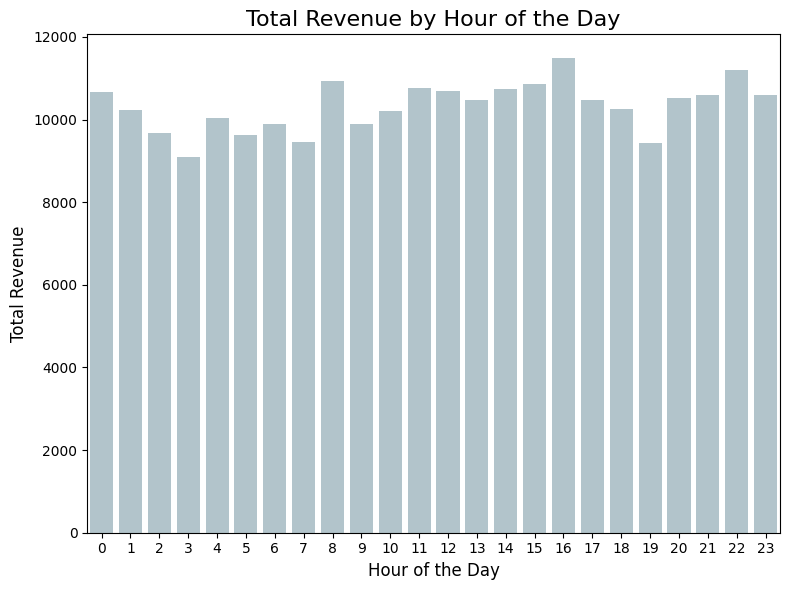

In [37]:
# Динаміка доходу у розрізі години доби.
hourly_data = df_21.groupby('Hour')['Revenue_By_Hour'].sum().reset_index()
plt.figure(figsize=(8, 6))
sns.barplot(data=hourly_data, x='Hour', y='Revenue_By_Hour', color='#AEC6CF')
plt.title("Total Revenue by Hour of the Day", fontsize=16)
plt.xlabel("Hour of the Day", fontsize=12)
plt.ylabel("Total Revenue", fontsize=12)
plt.tight_layout()
plt.show()

Найвищий дохід спостерігається о 16 годині, що може вказувати на популярність обідів, ранніх вечерь або активність клієнтів у післяобідній час.
Мінімальний дохід припадає на 19 годину, що виглядає незвично та може свідчити про потенційні технічні помилки в даних або ж низький попит у цей час через якісь зовнішні фактори (наприклад, менше клієнтів через конкуренцію чи зміну графіків).
Але дані виглядають доволі рівномірно також вночі, тож цей датасет скоріше має згенеровані дані, тому занурюватися в аналіз по годинах за такого розподілу не вдасться.

# 12. Що впливає на формування доходу?

In [38]:
# Дослідимо кількість та ціну позицій меню.
query_22 = f"""
SELECT
    Menu_Item,
    SUM(Quantity) AS Total_Quantity,
    AVG(Price_per_item) AS Avg_Price_Per_Item,
    SUM(Revenue) AS Total_Revenue
FROM `my-educational-project-444514.Restaurant_sales.Italian_sales`
GROUP BY Menu_Item
ORDER BY Total_Revenue DESC;
"""

df_22= execute_and_print_query(query_22)

,Menu_Item,Total_Quantity,Avg_Price_Per_Item,Total_Revenue
0,Fettuccine Alfredo,3089,13.0,40157.0
1,Spaghetti Carbonara,2983,12.0,35796.0
2,Lasagna,2999,11.5,34488.5
3,Margherita Pizza,2914,10.0,29140.0
4,Caprese Salad,2821,8.0,22568.0
5,Minestrone Soup,2990,7.0,20930.0
6,Tiramisu,3148,6.5,20462.0
7,Panna Cotta,3016,5.5,16588.0
8,Bruschetta,2822,5.0,14110.0
9,Gelato,2998,4.5,13491.0


Візуально аналізуючи дані можна побачити:
Fettuccine Alfredo приносить найбільший загальний дохід (40157.0) завдяки високій ціні (13.0) та високій кількості проданих одиниць (3089).
Gelato має найменший дохід (13491.0), що пов'язано як з низькою ціною (4.5), хоч зі схожою кількістю продажів (2998).
Товари з вищою ціною, як Fettuccine Alfredo і Spaghetti Carbonara, загалом приносять більше доходу. Це пояснюється як їхньою вищою ціною, так і високою кількістю продажів.
Водночас товари з нижчою ціною, як Gelato і Bruschetta, мають схожі обсяги продажів, але нижчий загальний дохід через свою ціну.

Так, кількість продажів грає ключову роль у визначенні загального доходу. Наприклад: Tiramisu і Minestrone Soup мають майже однакові кількості продажів (3148 і 2990), але дохід від Tiramisu вищий завдяки більшій ціні (6.5 проти 7.0).


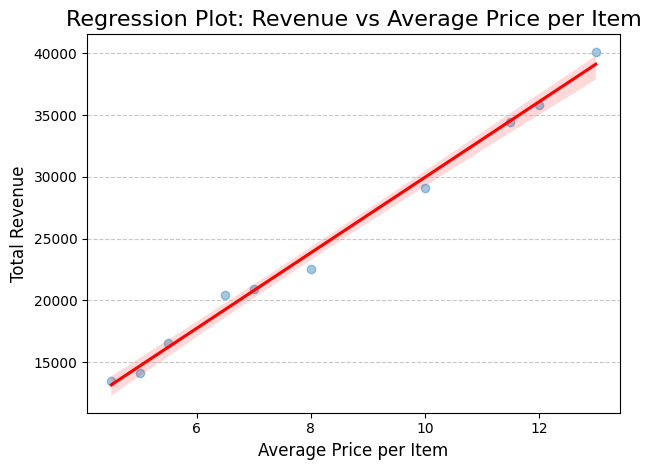

In [39]:
# Перевірка висновку за допомогою регресійного аналізу.
# Регресійний аналіз для виявлення трендів: чи зростає дохід зі збільшенням ціни.
sns.regplot(data = df_22, x = 'Avg_Price_Per_Item', y = 'Total_Revenue', scatter_kws = {'alpha': 0.4}, line_kws = {'color': 'red'});
plt.title("Regression Plot: Revenue vs Average Price per Item", fontsize=16)
plt.xlabel("Average Price per Item", fontsize=12)
plt.ylabel("Total Revenue", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

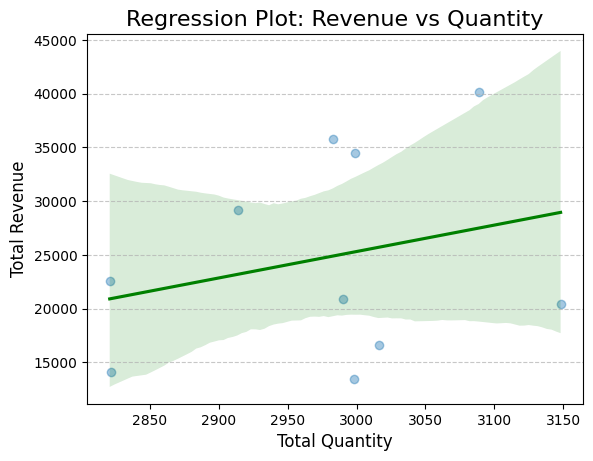

In [40]:
# Регресійний аналіз для виявлення трендів: чи зростає дохід зі збільшенням кількості проданих позицій.
sns.regplot(data=df_22, x='Total_Quantity', y='Total_Revenue', scatter_kws={'alpha': 0.4}, line_kws={'color': 'green'})
plt.title('Regression Plot: Revenue vs Quantity', fontsize=16)
plt.xlabel('Total Quantity', fontsize=12)
plt.ylabel('Total Revenue', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

                    Avg_Price_Per_Item  Total_Quantity  Total_Revenue
Avg_Price_Per_Item            1.000000        0.191698        0.99664
Total_Quantity                0.191698        1.000000        0.26769
Total_Revenue                 0.996640        0.267690        1.00000


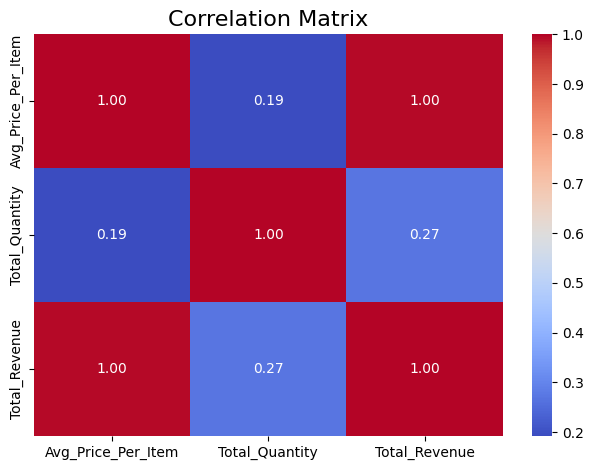

In [41]:
correlation_matrix = df_22[['Avg_Price_Per_Item', 'Total_Quantity', 'Total_Revenue']].corr(method='pearson')
print(correlation_matrix)
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix", fontsize=16)
plt.tight_layout()
plt.show()

Аналіз даних показує, що загальний дохід чітко корелює з ціною продукту, оскільки на графіку спостерігається прямолінійна залежність між цими змінними. Це свідчить про те, що зміна ціни має найбільший вплив на дохід. Натомість кількість має значно менший вплив, оскільки на графіку точки розкидані навколо прямої, що вказує на слабшу кореляцію або її відсутність. Тому рекомендовано зосередити увагу на товарах з високою ціною, оскільки вони можуть забезпечити більший дохід. Також для підвищення доходу необхідно оцінити маркетингові стратегії для товарів із низькою ціною, щоб підвищити їхній продаж.

**Загальний висновок:**


Аналіз продажів показує, що основні страви є найприбутковішою категорією у меню, що становить понад 56% від загального доходу. Ця категорія значно перевищує за доходом закуски (23.25%) та десерти (20.40%). Високий дохід від основних страв можна пояснити їхньою вищою ціною, що дає змогу отримувати більший прибуток навіть за дещо менші обсяги продажів порівняно з іншими категоріями. До того ж, основні страви користуються стабільним попитом протягом року, з деякими сезонними коливаннями, але загалом залишаються на першому місці за доходністю.

Аналіз страв у межах основного меню також показує, що такі страви, як Феттучіне Альфредо та Спагеті Карбонара, є найбільш прибутковими завдяки поєднанню високої ціни та великої кількості продажів. Це підкреслює важливість не лише ціни, але й популярності страви, що може впливати на обсяги продажів.З іншого боку, закуски та десерти мають менший дохід, що може бути зумовлено як меншою ціною, так і більш сезонним попитом. Наприклад, закуски мають найменший дохід у січні, тоді як десерти показують піки влітку, але мають значні коливання впродовж року. Це може вказувати на необхідність перегляду асортименту та стратегії маркетингу для цих категорій.

Окрім того, сезонність продажів має значення для кожної категорії. Основні страви знижують свою популярність у червні, тоді як закуски та десерти можуть демонструвати як спади, так і зростання, залежно від місяця. Використання сезонних акцій та спеціальних пропозицій, таких як комбо-меню або акції на певні страви, може допомогти підтримати або збільшити продажі в "низькі" сезони, наприклад, у січні чи лютому.
Загальні стратегії для ресторану повинні орієнтуватися на збільшення продажів основних страв, що є основним джерелом доходу. Рекомендується зосередити маркетингові зусилля на просуванні популярних та високоприбуткових страв, таких як Феттучіне Альфредо, у літні та осінні місяці. Одночасно варто переглянути стратегії для закусок і десертів, щоб покращити їхню прибутковість, а також розробити акції для зимових місяців, коли попит на ці категорії знижується.

Загалом, основним фактором, що формує дохід, є саме ціна продукту та попит на основні страви. Для максимізації прибутку рекомендується зосередитись на стратегіях, що включають високоякісні продукти з високими цінами та обсягами продажів, при цьому оптимізуючи асортимент закусок та десертів для підвищення їхньої привабливості та доходності.